In [1]:
%matplotlib inline
import epi_prediction
import numpy as np

##Import Data

In [2]:
src_dir = '/Users/johnbonihalab/data/chuyu/modalities/'

control_filter = lambda file_name: 'CON' in file_name
patient_filter = lambda file_name: 'PAT' in file_name

In [3]:
epi_paths = epi_prediction.get_epi_paths(src_dir, patient_filter, control_filter)

In [4]:
import sys

import nibabel as nib
import nilearn as nil

def load_data(fs):
    wm_image = nib.load('masks/white.nii')

    def verbose_load(f):
        sys.stdout.write('#')
        return nil.image.resample_img(f, 
                                      target_shape=wm_image.shape, 
                                      target_affine=wm_image.get_affine())

    print('-' * len(fs))
    
    return np.vstack([verbose_load(f).get_data().flatten() for f in fs])

In [5]:
pats_than_cons = lambda mod: epi_paths[mod]['pats'] + epi_paths[mod]['cons']

In [6]:
mat = np.hstack([load_data(pats_than_cons('dmean')), 
                load_data(pats_than_cons('fa')),
                load_data(pats_than_cons('kmean'))])

--------------------------------------------------------------------
####################################################################--------------------------------------------------------------------
####################################################################--------------------------------------------------------------------
####################################################################

In [7]:
mat.shape

(68, 2707887)

In [8]:
labels = len(epi_paths['dmean']['pats']) * [1] + len(epi_paths['dmean']['cons']) * [0]

In [9]:
len(labels)

68

In [10]:
labels_arr = np.array(labels)

##Create Feature Selection That Combines Modalities

In [11]:
from __future__ import division

dist = (int)(mat.shape[1]/3)

index_map = {"dmean": (0, dist),
             "fa":  (dist, 2 * dist),
             "kmean": (2*dist, 3*dist)}


__Combine Probalities from the SVM Outputs__

_Know the Best Params for Each SVM from other experiments_

In [24]:
##Commented Out Are For After searching for best params with C of C
#params_map = dict(dmean=dict(C=10, k=50, thresh=.5),
#                      kmean=dict(C=1, k=500, thresh=.2),
#                      fa=dict(C=1, k=50, thresh=.5))

#Below are params from pre-C of C experiments
params_map = dict(dmean=dict(C=.1, k=500, thresh=.2),
                      kmean=dict(C=1, k=500, thresh=.2),
                      fa=dict(C=.1, k=500, thresh=.2))

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif

def new_pipe(mod): 
    svc = SVC()
    svc.kernel='linear'
    svc.C = params_map[mod]['C']
    svc.probability=True
    k = params_map[mod]['k']
    thresh = params_map[mod]['thresh']
    masker = epi_prediction.SimpleMaskerPipeline(thresh)
    return Pipeline([
        ('columns', epi_prediction.ColumnSelector(index_map[mod])),
        ('whitematter', masker),
        ('anova', SelectKBest(k=k)),
        ('svc', svc)
    ])
    
svcs = [new_pipe(m) for m in params_map]

In [26]:
combined_alg = epi_prediction.ProbableBinaryEnsembleAlg(svcs)

In [27]:
cv_combos, cv_combos_train = epi_prediction.verbose_cv(mat, labels_arr, combined_alg, n_folds=6, verbose=False)

####
####
####
####
####
####


In [28]:
cv_combos.avg_f1_score()

0.77354312354312349

In [29]:
cv_combos.normalized_confusion_matrix()

array([[ 0.83333333,  0.16666667],
       [ 0.21875   ,  0.78125   ]])

In [30]:
cv_combos.f1_scores()

[0.92307692307692302,
 0.80000000000000004,
 0.90909090909090906,
 0.59999999999999998,
 0.5,
 0.90909090909090906]

In [32]:
cv_combos.avg_sensitivity_score()

0.77777777777777768

In [33]:
cv_combos.avg_specificity_score()

0.83333333333333337

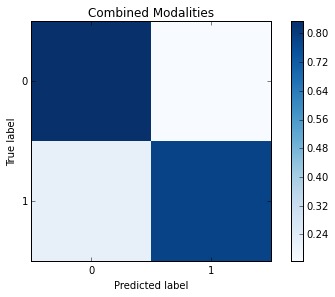

In [34]:
epi_prediction.plot_confusion_matrix(cv_combos.normalized_confusion_matrix(), "Combined Modalities")

##Good Results, Lets Compare With Removing Modalities

In [35]:
[m for m in index_map]

['fa', 'dmean', 'kmean']

In [36]:
svcs_no_kmean = [new_pipe(m) for m in ['fa', 'dmean']]

In [37]:
combined_alg_no_kmean = epi_prediction.ProbableBinaryEnsembleAlg(svcs_no_kmean)
cv_combos_no_kmean, cv_combos_train_no_kmean = epi_prediction.verbose_cv(mat, 
                                                                         labels_arr, 
                                                                         combined_alg_no_kmean,
                                                                         n_folds=6, 
                                                                         verbose=False)

####
####
####
####
####
####


In [38]:
cv_combos_no_kmean.avg_f1_score()

0.69627039627039622

In [41]:
cv_combos_no_kmean.avg_sensitivity_score()

0.68888888888888877

In [42]:
cv_combos_no_kmean.avg_specificity_score()

0.80555555555555547

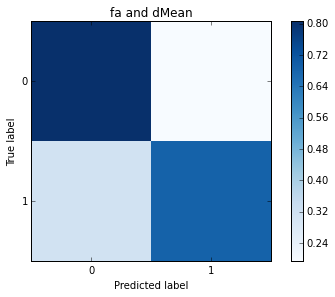

In [39]:
epi_prediction.plot_confusion_matrix(cv_combos_no_kmean.normalized_confusion_matrix(), "fa and dMean")

In [40]:
cv_combos_no_kmean.normalized_confusion_matrix()

array([[ 0.80555556,  0.19444444],
       [ 0.3125    ,  0.6875    ]])

_kMean is a major contributor, next examine contribution from other 2_

In [43]:
svcs_no_fa = [new_pipe(m) for m in ['kmean', 'dmean']]
combined_alg_no_fa = epi_prediction.ProbableBinaryEnsembleAlg(svcs_no_fa)
cv_combos_no_fa, cv_combos_train_no_fa = epi_prediction.verbose_cv(mat, 
                                                                   labels_arr, 
                                                                   combined_alg_no_fa,
                                                                   n_folds=6, 
                                                                   verbose=False)

####
####
####
####
####
####


In [44]:
cv_combos_no_fa.avg_f1_score()

0.73196248196248181

In [45]:
cv_combos_no_fa.avg_sensitivity_score()

0.74444444444444446

In [47]:
cv_combos_no_fa.avg_specificity_score()

0.80555555555555547

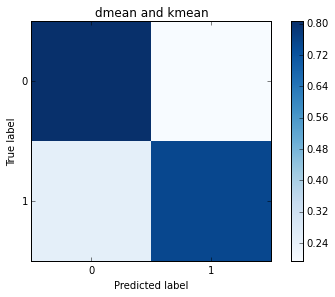

In [48]:
epi_prediction.plot_confusion_matrix(cv_combos_no_fa.normalized_confusion_matrix(), "dmean and kmean")

In [49]:
cv_combos_no_fa.normalized_confusion_matrix()

array([[ 0.80555556,  0.19444444],
       [ 0.25      ,  0.75      ]])

_let's try one more time with no dmean_

In [50]:
svcs_no_dmean = [new_pipe(m) for m in ['kmean', 'fa']]
combined_alg_no_dmean = epi_prediction.ProbableBinaryEnsembleAlg(svcs_no_dmean)
cv_combos_no_dmean, cv_combos_train_no_dmean = epi_prediction.verbose_cv(mat, 
                                                                         labels_arr, 
                                                                         combined_alg_no_dmean,
                                                                         n_folds=6, 
                                                                         verbose=False)

####
####
####
####
####
####


In [51]:
cv_combos_no_dmean.avg_f1_score()

0.72457912457912454

In [52]:
cv_combos_no_dmean.avg_sensitivity_score()

0.75

In [53]:
cv_combos_no_dmean.avg_specificity_score()

0.75

In [54]:
cv_combos_no_dmean.normalized_confusion_matrix()

array([[ 0.75,  0.25],
       [ 0.25,  0.75]])

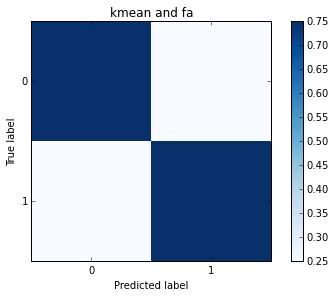

In [55]:
epi_prediction.plot_confusion_matrix(cv_combos_no_dmean.normalized_confusion_matrix(), "kmean and fa")